In [1]:

import pickle
import os
import h5py
from PIL import Image
import numpy as np
import math
import random
import transforms3d
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

2024-12-12 08:09:37.162405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 08:09:37.179628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 08:09:37.184783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 08:09:37.198335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 08:09:38.911136: W tensorflow/comp

In [2]:
# Load the dataset

def load_data(input_dir, load_images=False):
    # Define paths to your pickle files
    image_file = os.path.join(input_dir, 'images.h5')
    laser_file = os.path.join(input_dir, 'lasers.pkl')
    odom_file = os.path.join(input_dir, 'odoms.pkl')
    goal_odom_file = os.path.join(input_dir, 'goal_odoms.pkl')
    velocity_file = os.path.join(input_dir, 'velocities.pkl')
    tf_file = os.path.join(input_dir, 'tfs.pkl')
    
    # Load the pickle files
    with open(laser_file, 'rb') as f:
        lasers_raw = pickle.load(f)
        lasers = []
        for laser in lasers_raw:
            lasers.append([100.0 if math.isnan(x) or math.isinf(x) else x for x in laser])
    with open(odom_file, 'rb') as f:
        current_poses = pickle.load(f)
    with open(goal_odom_file, 'rb') as f:
        goal_poses = pickle.load(f)
    with open(velocity_file, 'rb') as f:
        velocities = pickle.load(f)
    # Split velocities into linear and angular components
    linear_velocities = np.array(velocities)[:, :2]  # Linear velocity (x, y)
    angular_velocities = np.array(velocities)[:, 2]  # Angular velocity (z)
    with open(tf_file, 'rb') as f:
        tfs = pickle.load(f)
    if load_images:
        print('loading images')
        with h5py.File(image_file, 'r') as f:
            image_keys = list(f.keys())
            images = [Image.fromarray(f[key][:]).resize((224, 224)) for key in image_keys]
        print('loaded images')
    else:
        images = [None]*len(lasers)

    combined_data = list(zip(images, lasers, current_poses, goal_poses, linear_velocities, angular_velocities, tfs))
    return  combined_data



In [3]:
import transforms3d

# Function to invert a transformation (translation + rotation)
def invert_transform(translation, rotation):
    # Convert the quaternion to a rotation matrix (3x3)
    rotation_matrix = transforms3d.quaternions.quat2mat([rotation[3], rotation[0], rotation[1], rotation[2]])[:3, :3]
    # Invert the rotation matrix (transpose of a rotation matrix is its inverse)
    rotation_matrix_inv = np.transpose(rotation_matrix)
    
    # Invert the translation (apply the inverse rotation to the negative translation)
    translation_inv = -np.dot(rotation_matrix_inv, [translation[0], translation[1], translation[2]])
    
    # Create the inverse quaternion (negate the vector part, keep the scalar part the same)
    rotation_inv = transforms3d.quaternions.qinverse([rotation[3], rotation[0], rotation[1], rotation[2]])
    return translation_inv, rotation_inv

# Function to apply the transformation (translation + rotation) to a point
def transform_point(translation, rotation, point):
    # Convert the point to a homogeneous vector (x, y, z, 1)
    point_homogeneous = np.array([point[0], point[1], point[2], 1.0])
    
    # Create the translation matrix (4x4)
    translation_matrix = np.identity(4)
    translation_matrix[0, 3] = translation[0]
    translation_matrix[1, 3] = translation[1]
    translation_matrix[2, 3] = translation[2]
    # Create the transformation matrix from translation and rotation
    rotation_matrix = np.identity(4)
    rotation_matrix[:3, :3] = transforms3d.quaternions.quat2mat(rotation)[:3, :3]
    # Combine translation and rotation into a single transformation matrix
    transformation_matrix = np.dot(translation_matrix, rotation_matrix)
    # Apply the transformation to the point
    transformed_point = np.dot(transformation_matrix, point_homogeneous)
    
    
    # Return the transformed point (x, y, z)
    return transformed_point[:3]

# Function to transform a point from odom to base_link frame
def transform_pose_to_base_link(translation, rotation, point_in_odom):
    # Get the inverse of the transformation
    translation_inv, rotation_inv = invert_transform(translation, rotation)
    
    # Convert the point from odom to base_link using the inverted transformation
    point_in_base_link = transform_point(translation_inv, rotation_inv, point_in_odom)
    
    return point_in_base_link

In [4]:

def augment_image(image):
    """Apply data augmentation to an image tensor."""
    image = tf.convert_to_tensor(image, dtype=tf.uint8)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

# def flip_image(image, motion_cmd):
#     image = tf.convert_to_tensor(image, dtype=tf.uint8)
#     image = tf.image.random_flip_left_right(image)
#     motion_cmd = [motion_cmd[0], -motion_cmd[1], -motion_cmd[2]] 
#     return image, motion_cmd
    
def serialize_metadata(dataset_length):
    feature = {
        'metadata': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"metadata"])),
        'length': tf.train.Feature(int64_list=tf.train.Int64List(value=[dataset_length]))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()
    
def serialize_example(laser, goal, motion_command, image=None):
    if image is not None:
        feature = {
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(image).numpy()])),
            # 'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
            'laser': tf.train.Feature(float_list=tf.train.FloatList(value=laser)),
            'goal': tf.train.Feature(float_list=tf.train.FloatList(value=goal)),
            'motion_command': tf.train.Feature(float_list=tf.train.FloatList(value=motion_command))
        }
    else:
        feature = {
            'laser': tf.train.Feature(float_list=tf.train.FloatList(value=laser)),
            'goal': tf.train.Feature(float_list=tf.train.FloatList(value=goal)),
            'motion_command': tf.train.Feature(float_list=tf.train.FloatList(value=motion_command))
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(file_path, lasers, goal, motion_commands, images, augment_images, flip_images, aug_sampling_probability):
    dataset_length = len(lasers)
    # Create a list of indices and shuffle it
    indices = list(range(dataset_length))
    random.shuffle(indices)
    with tf.io.TFRecordWriter(file_path) as writer:
        writer.write(serialize_metadata(dataset_length))
        for i in indices:
            if len(images) !=0:
                example = serialize_example(
                    lasers[i], goal[i], motion_commands[i], images[i]
                )
                writer.write(example)
                if random.random() > aug_sampling_probability:
                    continue
                if augment_images:
                    augmented_img = augment_image(images[i])
                    augmented_example = serialize_example(
                        lasers[i], goal[i], motion_commands[i], augmented_img
                    )
                    writer.write(augmented_example)
                # if flip_images:
                #     flipped_img, flipped_motion_cmd = flip_image(images[i], motion_commands[i])
                #     flipped_example = serialize_example(
                #         lasers[i], goal[i], flipped_motion_cmd, flipped_img
                #     )
                #     writer.write(flipped_example)
            else:
                 example = serialize_example(
                lasers[i], goal[i], motion_commands[i]
            )
                writer.write(example)



In [ ]:
sampled_lasers = []
sampled_images = []
sampled_goals = []
sampled_motion_commands = []
num_bins = 10  # Number of bins
samples_per_bin = 29000  # Number of samples per bin

x = np.array(goal)[:,1]
# Create bins based on 'x' values
bins = np.linspace(x.min(), x.max(), num_bins + 1)  # Create bin edges

# Digitize the 'x' values to assign them to bins
bin_indices = np.digitize(x, bins)



# Sample uniformly from each bin
for i in range(1, num_bins + 1):
    # Get indices of data points in the current bin
    indices_in_bin = np.where(bin_indices == i)[0]
    
    if len(indices_in_bin) > 0:
        # Randomly sample from the bin
        sampled_indices = np.random.choice(indices_in_bin, size=min(samples_per_bin, len(indices_in_bin)), replace=True)
        sampled_lasers.extend(np.array(lasers)[sampled_indices])
        if use_images:
            sampled_images.extend(np.array(images)[sampled_indices])
        sampled_goals.extend(np.array(goal)[sampled_indices])
        sampled_motion_commands.extend(np.array(motion_commands)[sampled_indices])

In [5]:
lasers = []
linear_velocities = []
angular_velocities = []
images = []
goals = []
target_distance = 0.2
forward_goal_thresh = 2.4
sampling_probability = 0.4
aug_sampling_probability = 0.5

root_folder = r"/work/nselva2s/rnd/robile_data_corr_07112024"
use_images = True
scale_output = False
augment_images = True
flip_images = False

for item in os.listdir(root_folder):
    item_path = os.path.join(root_folder, item)
    if item == 'tfrecords':
        continue
    if os.path.isdir(item_path):
        data = load_data(os.path.join(root_folder, item_path), load_images=use_images)
        print('loaded data')
        for i, (_, _, _, goal_pose1, _, _, _) in enumerate(data):
            for j, (image2, laser2, current_pose2, _, linear_velocity2, angular_velocity2, tf2) in enumerate(data[i:]):   
                if random.random() > sampling_probability:
                    continue
                distance = np.sqrt((goal_pose1[0] - current_pose2[0]) ** 2 + (goal_pose1[1] - current_pose2[1]) ** 2)
                if distance >= target_distance:
                    goal_baselink = transform_pose_to_base_link(tf2[0], tf2[1], goal_pose1)
                    goal_distance = distance
                    goal_angle = math.atan2(goal_baselink[1],goal_baselink[0])
                    if abs(goal_angle) < forward_goal_thresh:
                        goals.append([goal_distance, goal_angle])
                        lasers.append(laser2)
                        if use_images:
                            images.append(image2)
                        linear_velocities.append(linear_velocity2)
                        angular_velocities.append(angular_velocity2)
                else:
                    break
                
print('get motion commands')
motion_commands = np.concatenate([np.expand_dims(np.array(linear_velocities)[:,0], axis=1), np.expand_dims(np.array(linear_velocities)[:,1], axis=1), np.expand_dims(angular_velocities, axis=1)], axis=1)  # Shape: (1000, 3)
if scale_output:
    scaler = StandardScaler()
    standardized_motion_commands = scaler.fit_transform(motion_commands)
    scaler_minmax = MinMaxScaler(feature_range=(-0.1, 0.1))
    motion_commands = scaler_minmax.fit_transform(standardized_motion_commands)



loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
get motion commands


In [6]:
tf_file = os.path.join(root_folder, 'tfrecords/corr_07112024_withImages_resized_augmented.tfrecord')
write_tfrecord(tf_file, lasers, goals, motion_commands, images, augment_images, flip_images, aug_sampling_probability)

2024-12-11 21:56:58.776993: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
len(lasers)

287484

/tmp/ipykernel_2424667/203946220.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


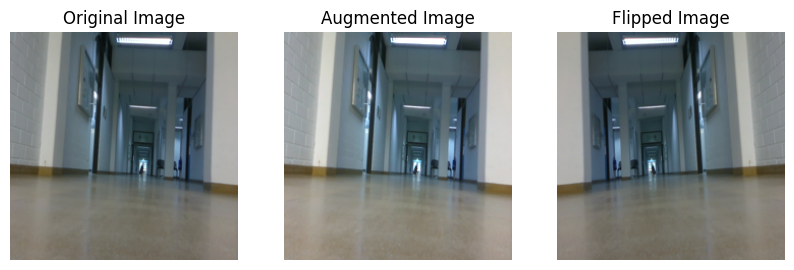

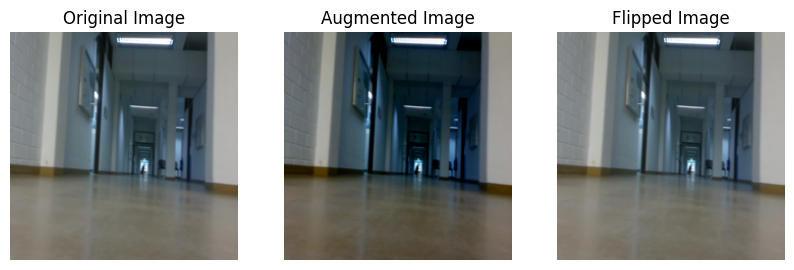

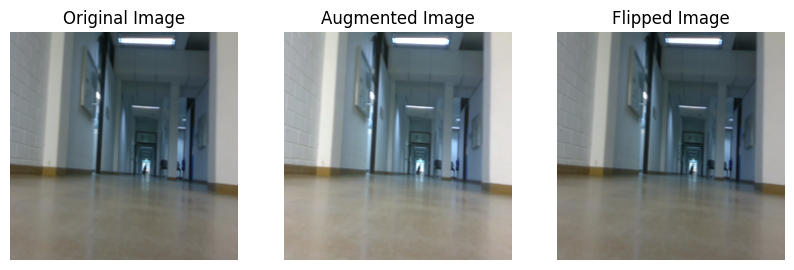

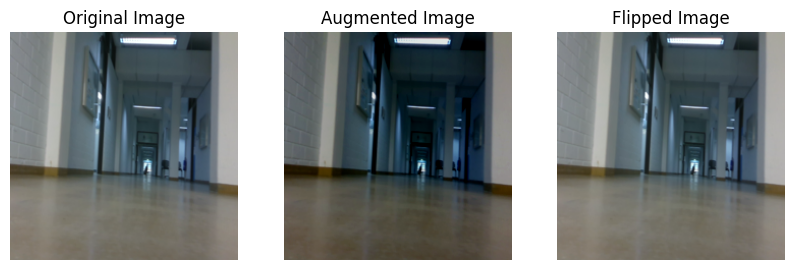

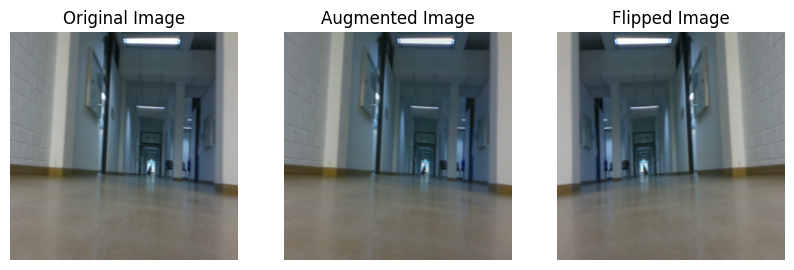

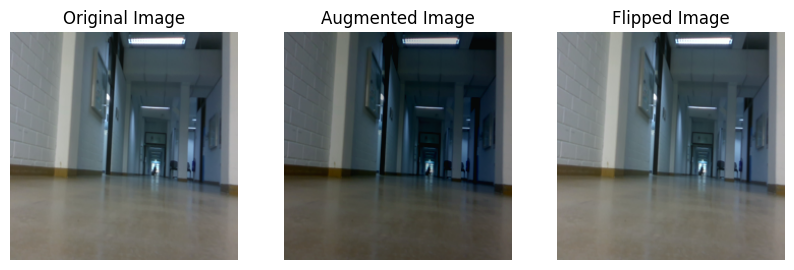

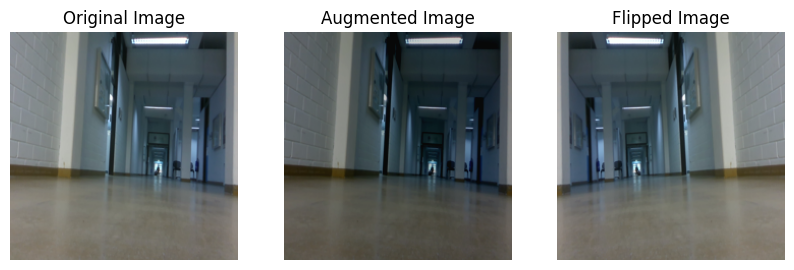

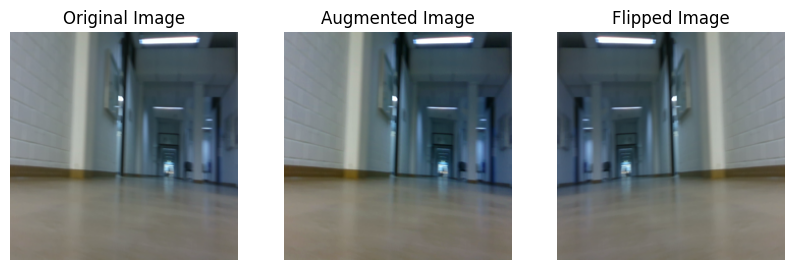

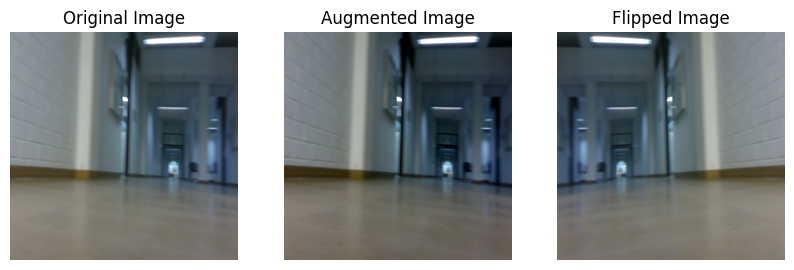

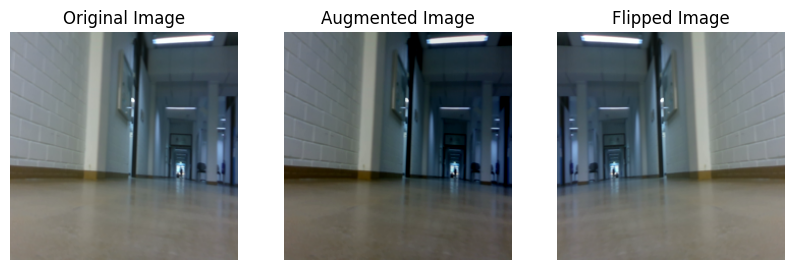

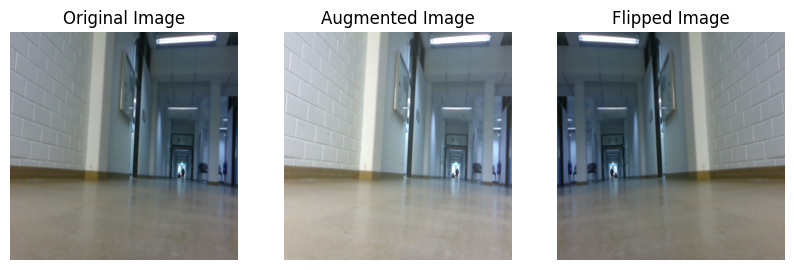

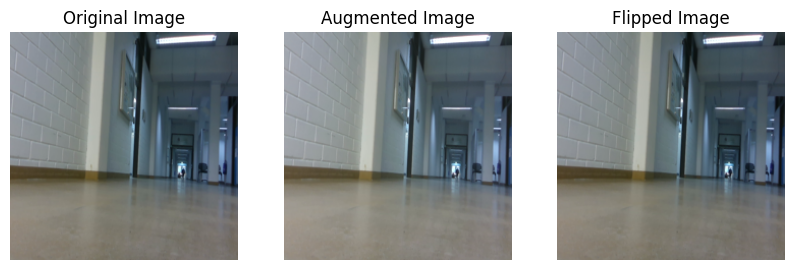

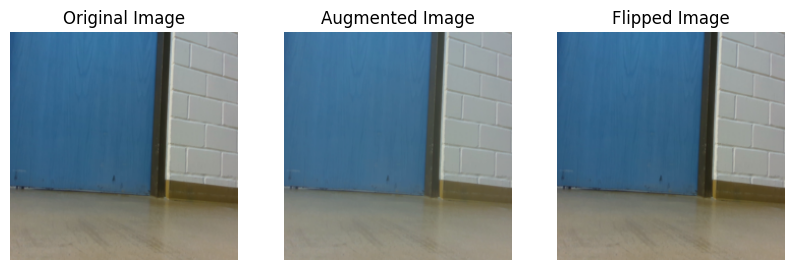

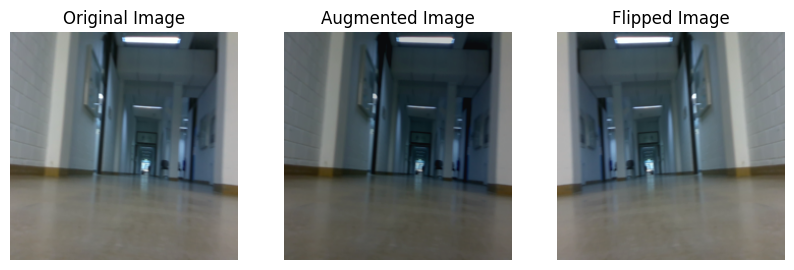

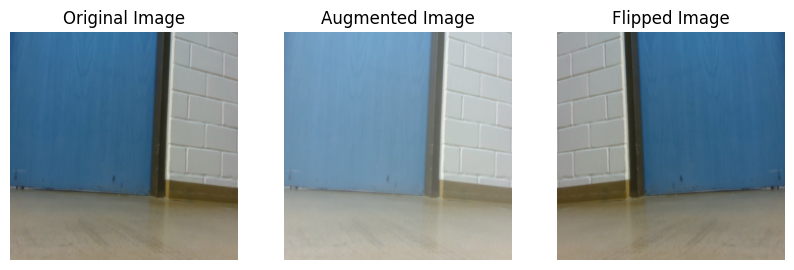

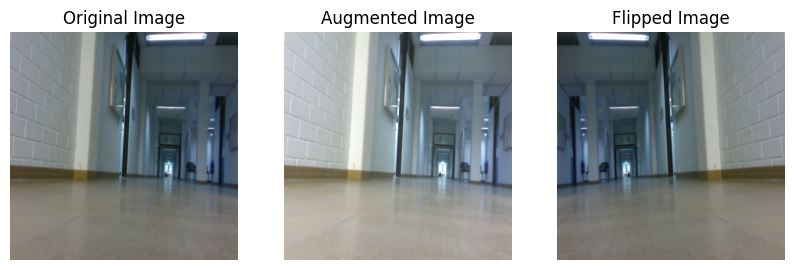

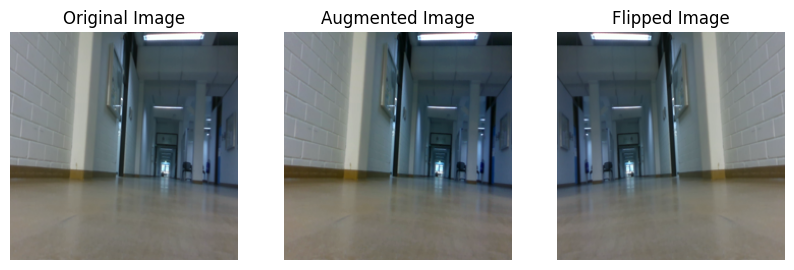

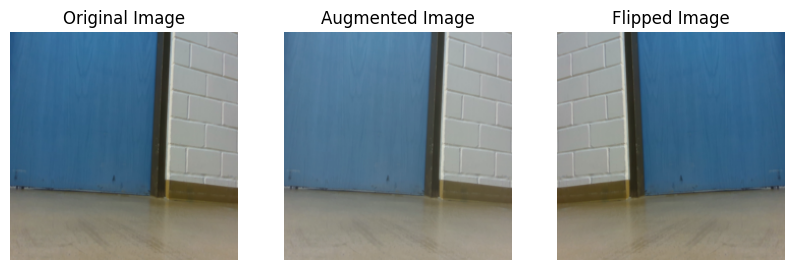

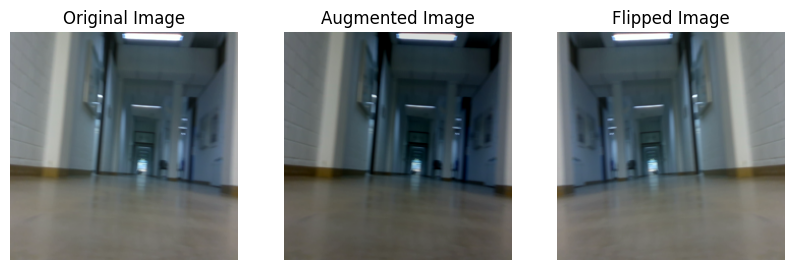

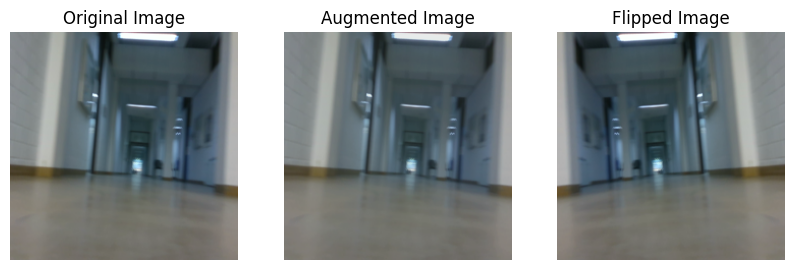

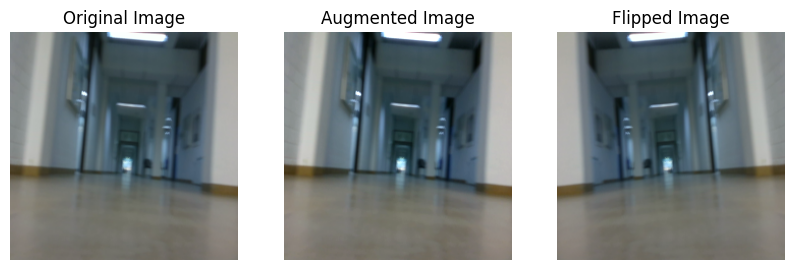

In [10]:
import matplotlib.pyplot as plt
count =0
for img in images:
    if random.random() > 0.5:
        augmented_img = augment_image(img)
        flipped_img, flipped_motion_cmd = flip_image(img, motion_commands[i])
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(tf.cast(img, tf.uint8))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Augmented Image")
        plt.imshow(tf.cast(augmented_img, tf.uint8))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Flipped Image")
        plt.imshow(tf.cast(flipped_img, tf.uint8))
        plt.axis('off')

        count = count +1

    if count>20:
        break

        
            

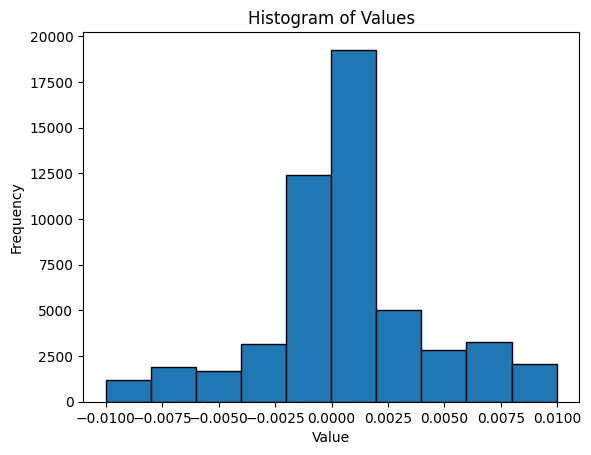

In [20]:
import matplotlib.pyplot as plt
plt.hist(np.array(motion_commands)[:,2][(abs(np.array(motion_commands)[:,2])<0.01)], bins=10, edgecolor='black')  # Adjust the number of bins as necessary
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [17]:
np.array(motion_commands)[:,2][(abs(np.array(motion_commands)[:,2])<1)]

array([-5.54470096e-03, -2.08108150e-05, -1.20492690e-05, ...,
        6.38825818e-03,  1.11025395e-02,  1.11025395e-02])

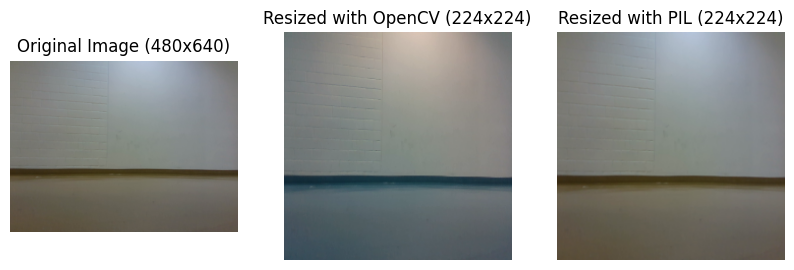

In [11]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Sample image array
image_array = np.array(images[0])

# Resize with OpenCV
resized_image_cv = cv2.resize(image_array, (224, 224))

# Resize with PIL
image_pil = Image.fromarray(image_array)
resized_image_pil = image_pil.resize((224, 224))

# Display the original and resized images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_array)
plt.title("Original Image (480x640)")
plt.axis("off")

# Resized with OpenCV
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(resized_image_cv, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title("Resized with OpenCV (224x224)")
plt.axis("off")

# Resized with PIL
plt.subplot(1, 3, 3)
plt.imshow(resized_image_pil)
plt.title("Resized with PIL (224x224)")
plt.axis("off")


plt.show()


In [8]:
! pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 62.5 MB 5.1 MB/s eta 0:00:011     |███████████████████▊            | 38.5 MB 40.0 MB/s eta 0:00:01
  distutils: /home/nselva2s/.local/lib/python3.9/site-packages
  sysconfig: /home/nselva2s/.local/lib64/python3.9/site-packages
  user = True
  home = None
  root = None
  prefix = None


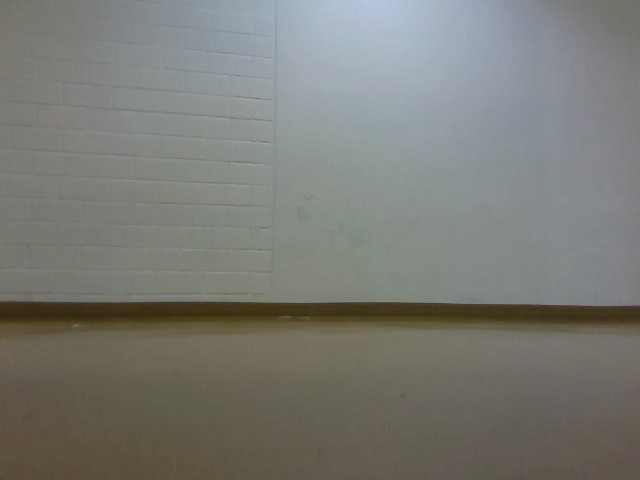

In [10]:
image_array

In [7]:


values = [[10], [20], [30], [40], [100]]  # 2D array required for scikit-learn
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_values = scaler.fit_transform(values)
print(rescaled_values.flatten())  # Flatten to 1D array

[0.         0.11111111 0.22222222 0.33333333 1.        ]


In [11]:

motion_commands = [[1,2,3],[20,30,40],[-2,-6,10]]
scaler = StandardScaler()
standardized_motion_commands = scaler.fit_transform(motion_commands)

In [13]:
standardized_motion_commands

array([[-0.54750873, -0.43193421, -0.91389428],
       [ 1.40299112,  1.38218948,  1.39161175],
       [-0.85548239, -0.95025527, -0.47771747]])